**Due date is Wednesday, February 17, 2021, 23:59 PST**

**ONLY write into the existing cells, and do NOT add any cells.**

# ELEC 400M / EECE 571M Assignment 1: Linear models for classification
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will be using linear models discussed in the lectures to perform a binary classification task. You will compare the performances of linear classification and logistic regression using suitable training algorithms. The implementation will be done in python using functions from the **NumPy** library. Please use **NumPy arrays** as data structures.

## Data Set
We consider the dataset of images of letters contained in file notMNIST.npz. In particular, you will use a smaller dataset that only contains the images from two letter classes: “C” (the positive class) and “J” (the negative class). The images are of size 28 × 28 pixels. The figure below shows 20 randomly selected image samples for the letters “C” and “J”.

<img src="sample_images.png" width="400">

You will apply the function `loadData` to generate the subset of images containing only letters “C” and “J”. This script organizes the total set of 3,745 images into smaller subsets containing 3,500 training images, 100 validation images and 145 test images. Their use will be further specified in the problem descriptions below.

Execute the two helper scripts provided below.

In [1]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.0
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(1)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
           
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Linear Classification

The first classifier is the linear classifier 
$$\hat{y}=\mathrm{sign}\left(\sum_{i=0}^dw_ix_i\right)\,$$
where $x_0=1$ so that $b=w_0x_0$ is the bias term and $x_1,\ldots, x_d$ are the input features.
The loss function for an input-output pair $(\underline{x}_n,y_n)$ and given model parameters $\underline{w}$ is 
$$L_n(\underline{w})= \mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$
The total loss for $N$ samples is 
$$L(\underline{w})= \frac{1}{N}\sum\limits_{n=1}^N\mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$



### Notes on classification
* The classification should be based on the $d=28\times 28=784$ intensity values in an image. This means that you need to flatten the 2D images to 1D input vectors $\underline{x}$ of length 784.
* The outputs $\hat{y}$ of the perceptron model are from $\{-1,+1\}$, while the target variable from the data set is from $\{0,1\}$. You need to make adjustements to account for this difference, which can include adjusting the data type.

### Loss Function [2 points]

Implement a function to compute the classification loss as defined above. The function has three input arguments: the weight vector, the feature vectors, and the labels. The binary labels are assumed to be from $\{-1,+1\}$. It returns the total loss (normalized with $N$, as above) associated with the input.

In [3]:
def ErrorRate (w, x, y):
    """Compute error rate for binary linear classifier"""
    # YOUR CODE HERE
    # compute y_hat
    y_hat = np.matmul(np.transpose(w), np.transpose(x))
    y_hat[y_hat<0.0] = -1
    y_hat[y_hat>0.0] = 1
    
    # compute loss
    error = np.sum(y_hat != (np.transpose(y))) / y_hat.shape[1]
    return error

In [4]:
"""Check that ErrorRate returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.) )"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[-1],[1],[-1]])
assert np.abs(ErrorRate(wtest1,xtest1,ytest1)-0.25)<0.01 
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[-1],[-1],[1],[1]])
assert np.abs(ErrorRate(wtest2,xtest2,ytest2)-0.0)<0.01 
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[-1],[1],[1],[1]])
assert np.abs(ErrorRate(wtest3,xtest3,ytest3)-0.6)<0.01 

### Perceptron Learning Algorithm [10 points]

Implement a function for the perceptron learning algorithm (PLA) which accepts four arguments: an inital weight vector, the data, the labels (binary $\{-1,+1\}$), and the maximal number of iterations it executes. It is thus a version of the PLA that is assured to terminate. The function returns the updated weight vector. 

**Note:** To pass the test cases, your PLA needs to select the misclassified sample to perform a model update in a deterministic manner as follows: from the training data $\{(x_1,y_1,), (x_2,y_2), \ldots,(x_N,y_N)\}$ select the misclassified sample $(x_i,y_i)$ with the smallest index $i$ for the PLA update.

In [5]:
def PLA(w, x, y, maxIter):

    # YOUR CODE HERE
    wIter = w
    iteration = 0
    while (iteration<maxIter) and (ErrorRate(wIter, x, y)>0):
        # extract the misclassified sample with least index
        y_hat = np.matmul(np.transpose(wIter), np.transpose(x)) # 1xN
        y_hat[y_hat<0.0] = -1
        y_hat[y_hat>0.0] = 1
        errorArray = np.array(y_hat != np.transpose(y)) # 1xN
        misIdx = 0
        for idx in range(0, y_hat.shape[1]):
            if errorArray[0, idx]:
                misIdx = idx
                break
        xMis = np.reshape(x[misIdx, :], (1, x.shape[1])) # 1x(d+1)
        # update weight
        wIter = wIter + np.transpose(y[misIdx]*xMis) # (d+1)x1 + (d+1)x1
        # increment iteration
        iteration = iteration + 1
    return wIter

In [6]:
"""Check that PLA returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[-1],[1],[-1]])
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[-1],[-1],[1],[1]])
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[-1],[1],[1],[1]])
assert np.linalg.norm(np.subtract(PLA(wtest1,xtest1,ytest1, 100),np.array([[-4],[0],[4]])))<0.01
assert np.linalg.norm(np.subtract(PLA(wtest1,xtest2,ytest2, 100),np.array([[-4.8],[6.4],[-6.4]])))<0.01
assert np.linalg.norm(np.subtract(PLA(wtest3,xtest3,np.array([[1],[-1],[-1],[1],[1]]), 100), np.array([[-1.],[-4.2],[-1.3]])))<0.01

Now test the `PLA` function on the data set.

Test the `PLA` function by training the classifier on the training data (`trainData`, `trainTarget`) with a maximum of 100 iterations, and measuring the cassification error using the testing data (`testData`, `testTarget`). Write the test script into the box below and let it print the classification error.

In [7]:
# YOUR CODE HERE
# load data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
# flatten x arrays and append the bias feature
trainData = np.reshape(trainData, (trainData.shape[0], trainData.shape[1]*trainData.shape[2]))
trainData = np.insert(trainData, 0, 1.0, axis=1)
testData = np.reshape(testData, (testData.shape[0], testData.shape[1]*testData.shape[2]))
testData = np.insert(testData, 0, 1.0, axis=1)
# we also flatten and append the validation set here,
# though not using it immediately
validData = np.reshape(validData, (validData.shape[0], validData.shape[1]*validData.shape[2]))
validData = np.insert(validData, 0, 1.0, axis=1)
# scale targets for train, test, val set to {-1, +1}
trainTarget = (trainTarget - 0.5)*2
testTarget = (testTarget - 0.5)*2
validTarget = (validTarget - 0.5)*2
# train
w0 = np.zeros((trainData.shape[1], 1))
w = PLA(w0, trainData, trainTarget, 100)
# test
errorRate = ErrorRate(w, testData, testTarget)
print(f"Classification error is {errorRate}")

Classification error is 0.041379310344827586


### Pocket algorithm [8 points]

Implement a function for the pocket algorithm which accepts three arguments: the data, the labels (binary $\{-1,+1\}$), and the number of iterations it executes. It should use the function `PLA` you developed above. It returns the updated weight vector.

**Note:** To pass the test cases, initialize the weight vector to the all-zero vector.

In [8]:
def pocket(x, y, T):
 
    # YOUR CODE HERE
    w = np.zeros((x.shape[1], 1))
    for t in range(0, T):
        # run PLA once
        wNew = PLA(w, x, y, 1)
        # compute errors
        error = ErrorRate(w, x, y)
        errorNew = ErrorRate(wNew, x, y)
        if errorNew < error:
            w = wNew
    return w

In [9]:
"""Check that Pocket algorithm returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[-1],[1],[-1]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[-1],[-1],[1],[1]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[-1],[1],[1],[1]])
assert np.linalg.norm(np.subtract(pocket(xtest1,ytest1, 10),np.array([[1.], [2.],[3.]])))<0.01
assert np.linalg.norm(np.subtract(pocket(xtest2,ytest1, 5),np.array([[-9.2],[-0.7],[3.5]])))<0.01
assert np.linalg.norm(np.subtract(pocket(xtest3,ytest3, 5),np.array([[ 0.1],[-2.],[3.1]])))<0.01

Test the `pocket` function by training the classifier on the training data `(trainData, trainTarget)` with 100 iterations, and measuring the cassification error using the testing data `(testData, testTarget)`. Write the test script into the box below and let it print the classiciation error.

In [10]:
# YOUR CODE HERE
# train
w = pocket(trainData, trainTarget, 100)
# test
errorRate = ErrorRate(w, testData, testTarget)
print(f"Classification error is {errorRate}")

Classification error is 0.08275862068965517


In the text box below, state the test error results for the PLA and pocket algorithm that you obtained. Briefly discuss if they are as you expected and why or why not.

The error from the PLA algorithm is 4.14%; the error from the pocket algorithm is 8.28%. So the pocket algorithm yields a larger error than the PLA algorithm.

This is what I expected. the pocket algorithm yields a larger error due to the deterministic method our PLA algorithm picks misclassified samples. If during any iteration of the pocket algorithm, the PLA algorithm picks a sample that leads to higher loss, the same sample will be picked up again in the next iteration, and the pocket algorithm will no longer update the weights.

If we employ a random picking strategy in our PLA algorithm, then the pocket algorithm may (or may not) be able to perform better than the PLA algorithm.

## Logistic Regression

**Note:** For classification with logistic regression, we consider that the **labels $y_n\in\{0,1\}$** are used. So please write your responses and your functions accordingly.

The second classifier we consider is logistic regression.  Logistic regression computes the probability measure
$$\hat{y}=\theta(\underline{w}^T\underline{x})$$
for a feature vector $\underline{x}$, where $\theta(z)=\mathrm{e}^s/(1+\mathrm{e}^s)$ is the logistic function, and $\hat{y}$ is interpretated as $\Pr(y=1)$. Given $N$ data samples $\underline{x}_n$ and labels $y_n$, the error measure for logistic regression is the binary cross-entropy loss 
$$L(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]\;.$$
For the following, you will consider the regularized loss function
$$L_\lambda(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]+\frac{\lambda}{2}\|\underline{w}\|_2^2$$
with the regularization parameter $\lambda \ge 0$. 

The training of the weight vector $\underline{w}$ will be performed through batch gradient descent. 


# Loss function [2 points]

Implement a function to compute the regularized cross-entropy loss as defined above. The function has four input arguments: the weight vector, the feature vectors, the labels (binary $\{0,1\}$), and the regularization parameter. It returns the regularized loss.

In [11]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

def crossEntropyLoss(w, x, y, reg):

    # YOUR CODE HERE
    wx = np.matmul(np.transpose(w), np.transpose(x))
    y_hat = np.transpose(sigmoid(wx)) # Nx1
    loss = (np.sum(-1.0*y*np.log(y_hat)-(1.0-y)*np.log(1.0-y_hat)) / y.shape[0]) + reg/2.0 * np.sum(np.square(w))
    return loss

In [12]:
"""Check that CrossEntropyLoss returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[0],[1],[0]])
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[0],[0],[1],[1]])
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[0],[1],[1],[1]])
assert np.abs(crossEntropyLoss(wtest1,xtest1,ytest1,reg=0.0)-2.25)<0.01 
assert np.abs(crossEntropyLoss(wtest2,xtest2,ytest2,reg=0.1)-0.49)<0.01 
assert np.abs(crossEntropyLoss(wtest3,xtest3,ytest3,reg=0.1)-4.77)<0.01 

### Gradient [4 points]

In the text box below, provide an analytical expression for the gradient of the regularized cross-entropy loss with respect to the weight vector. Note that the labels $y_n\in\{0,1\}$.

We can take derivatives for the classification term and the regularization term separately.

1. For the classification term,
$$\frac{\partial L}{\partial \underline{w}} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \underline{s}} \frac{\partial \underline{s}}{\partial \underline{w}} = \frac{1}{N}\sum\limits_{n=1}^N\left[ (\frac{\hat{y}_n-y_n}{\hat{y}_n(1-\hat{y}_n)}) (\hat{y}_n(1-y_n)) (\underline{x}_n) \right] = \frac{1}{N}\sum\limits_{n=1}^N\left[ (\hat{y}_n-y_n) (\underline{x}_n) \right]$$, where $\underline{s} = \underline{w}^T\underline{x}$. This can be rewritten as a multiplication of matrices:
$$\frac{\partial L}{\partial \underline{w}} = \frac{1}{N}(\hat{\underline{y}}-\underline{y})^T X$$, where $X$ is the $N \times (d+1)$ data matrix. 
2. For the regularization term,
$$\frac{\partial L}{\partial \underline{w}} = \lambda \underline{w}$$.

The gradient of the total loss therefore is
$$\frac{\partial L}{\partial \underline{w}} = \frac{1}{N}(\hat{\underline{y}}-\underline{y})^T X + \lambda \underline{w}^T$$. The result is a $1 \times (d+1)$ vector.

Implement a function to compute the gradient. The function has four input arguments: the weight vector, the feature vectors, the labels (binary $\{0,1\}$), and see the test cases below for the array format) and the regularization parameter. It returns the gradient.

In [13]:
def gradCE(w, x, y, reg):
    
    # YOUR CODE HERE
    # get N
    N = x.shape[0]
    # compute y_hat
    wx = np.matmul(np.transpose(w), np.transpose(x))
    y_hat = sigmoid(wx) # 1xN
    # compute dL/dw
    dLdw = (1.0/N * np.matmul((y_hat - np.transpose(y)), x)) + reg*np.transpose(w) # 1x(d+1)
    dLdw = np.transpose(dLdw)
    return dLdw

In [14]:
"""Check that gradeCE returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[0],[1],[0]])
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[0],[0],[1],[1]])
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[0],[1],[1],[1]])
assert np.linalg.norm(np.subtract(gradCE(wtest1,xtest1,ytest1,reg=0),np.array([[0.50],[0.75],[1.0]])))<0.01
assert np.linalg.norm(np.subtract(gradCE(wtest2,xtest2,ytest2,reg=1),np.array([[-0.05],[0.36],[-3.01]])))<0.01
assert np.linalg.norm(np.subtract(gradCE(wtest3,xtest3,ytest3,reg=1),np.array([[2.39],[-1.01],[3.84]])))<0.01

### Gradient Descent Implementation [3 points]
Using the gradient and cross-entropy loss function above, implement the batch gradient descent algorithm. The function should accept seven arguments: the weight vector, the feature vectors, the labels (binary $\{0,1\}$), the learning rate, the number of epochs, the regularization parameter, and an error tolerance (set to $10^{-7}$ for the experiments). The error tolerance will be used to terminate the gradient descent early, if the difference (i.e., its 2-norm) between the old and updated weights after one iteration is below the error tolerance. The function should return the optimized weight vector and the training loss. 

In [15]:
def grad_descent(w, x, y, eta, iterations, reg, error_tol):
    # YOUR CODE HERE
    # initialize weight and losses
    wCurr = w
    losses = []
    # descend gradients
    for t in range(0, iterations):
        # compute gradient vector
        g = gradCE(wCurr, x, y, reg)
        # update weights
        wNext = wCurr - eta * g
        # compute loss
        loss = crossEntropyLoss(wNext, x, y, reg)
        losses.append(loss)
        # terminate early if within error tolerence
        if np.linalg.norm((wNext - wCurr), 'fro') < error_tol:
            wCurr = wNext
            break
        else:
            wCurr = wNext
    # return last weights and losses
    return (wCurr, losses)

## Tuning the Learning Rate [4 Points]: 
Write a script that excutes logistic regression using the gradient descent function from above to classify the two classes in the notMNIST dataset, loaded with the  `loadData` function. 

Set the number of epochs to $2,000$ and use the regularization parameter $\lambda=0$. 

For the learning rate, consider $\eta=5\cdot 10^{-3},\,10^{-3},\,10^{-4}$.

Train the classifier on the training data (`trainData, trainTarget`).

The script should plot the training loss as a function of the number of training epochs.

Text(0, 0.5, 'Loss')

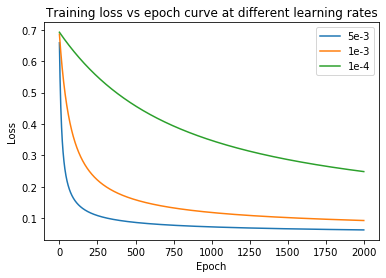

In [16]:
# YOUR CODE HERE
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# set up hyperparameters
iterations = 2000
reg = 0
error_tol = 1e-7

# scale targets for train, test, val set to {0, 1}
trainTarget = (trainTarget + 1)/2
testTarget = (testTarget + 1)/2
validTarget = (validTarget + 1)/2

# train with learning rate 5e-3
w0 = np.zeros((trainData.shape[1], 1))
eta = 5e-3
w, losses = grad_descent(w0, trainData, trainTarget, eta, iterations, reg, error_tol)
ax.plot(losses, label='5e-3')

# train with learning rate 1e-3
w0 = np.zeros((trainData.shape[1], 1))
eta = 1e-3
w, losses = grad_descent(w0, trainData, trainTarget, eta, iterations, reg, error_tol)
ax.plot(losses, label='1e-3')

# train with learning rate 1e-4
w0 = np.zeros((trainData.shape[1], 1))
eta = 1e-4
w, losses = grad_descent(w0, trainData, trainTarget, eta, iterations, reg, error_tol)
ax.plot(losses, label='1e-4')

# beautify the graph
ax.legend(loc='best')
ax.set_title('Training loss vs epoch curve at different learning rates')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In the text box below, briefly discuss the impact of the learning rate $\eta$ on the training time. 

From the graph above, we can see the training loss descends faster with larger learning rate. So larger learning rate allows us to reach the same loss in less iterations, thus saving training time.

In practice however, a learning rate too large may lead to a gradient update "skip over" a minimum if the gradient is already at somewhere close to a minimum. In some cases, the loss may not converge. 

### Generalization [3 points]:
Fix the learning rate to $\eta=0.005$, and consider values for the regularization parameter $\lambda = 0.001,\, 0.01,\, 0.1$. Measure the classification error using the validation and test sets and state them in your answer in the text box below. Comment on the effect of regularization on performance as well as the rationale behind tuning $\lambda$ using the validation set.

In [19]:
""" Here you can write your code for the generalization test"""

# YOUR CODE HERE
def Generalize(eta, lamb, iterations, error_tol, w0, evalData, evalTarget, dataStr):
    w, losses = grad_descent(w0, trainData, trainTarget, eta, iterations, lamb, error_tol)
    # we expect evalTarget to be in {0, 1}. Map target to {-1, +1}
    evalTargetRemapped = evalTarget*2 - 1
    errorRate = ErrorRate(w, evalData, evalTargetRemapped)
    print(f"{dataStr} error rate is {errorRate}")
    
# set up common hyper-parameters
eta = 5e-3
iterations = 2000
error_tol = 1e-7
w0 = np.zeros((trainData.shape[1], 1))

# train with lambda = .001
reg1 = 1e-3
Generalize(eta, reg1, iterations, error_tol, w0, validData, validTarget, 'Lambda = 1e-3, Validation')
Generalize(eta, reg1, iterations, error_tol, w0, testData, testTarget, 'Lambda = 1e-3, Test')

# train with lambda = .01
reg2 = 1e-2
Generalize(eta, reg2, iterations, error_tol, w0, validData, validTarget, 'Lambda = 1e-2, Validation')
Generalize(eta, reg2, iterations, error_tol, w0, testData, testTarget, 'Lambda = 1e-2, Test')

# train with lambda = .1
reg3 = 1e-1
Generalize(eta, reg3, iterations, error_tol, w0, validData, validTarget, 'Lambda = 1e-1, Validation')
Generalize(eta, reg3, iterations, error_tol, w0, testData, testTarget, 'Lambda = 1e-1, Test')

Lambda = 1e-3, Validation error rate is 0.05
Lambda = 1e-3, Test error rate is 0.034482758620689655
Lambda = 1e-2, Validation error rate is 0.05
Lambda = 1e-2, Test error rate is 0.034482758620689655
Lambda = 1e-1, Validation error rate is 0.05
Lambda = 1e-1, Test error rate is 0.034482758620689655


The validation and test errors for the three lambda's, given 2000 training epochs are:
1. For $\lambda = .001$, val: 5%, test: 3.45%;
2. For $\lambda = .01$, val: 5%, test: 3.45%;
3. For $\lambda = .1$, val: 5%, test: 3.45%.

Effects of regularization on performance:
1. Regularization reduces overfitting by penalizing 1) large weights or 2) a weight vector for which the weights for a subset of features dominate.
2. Regularization may lead to underfitting if $\lambda$ is set to a value too large. For example, if we use 6000 iterations, then the test error rate with $\lambda = 1$ becomes larger than smaller $\lambda$'s.


Rationale behind tuning $\lambda$ with the validation set:
* We tune $\lambda$ with the validation set because overfitting happens when weights become too well-suited for the training set, but do not generalize well to other data. Since samples from the validation set are not from the training set, tuning with the validation set allows us to check the extent of overfitting.